In [69]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import data
importlib.reload(data)
from data import Data

# Set up figure style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 10)

# Load all experimental data
d = Data()

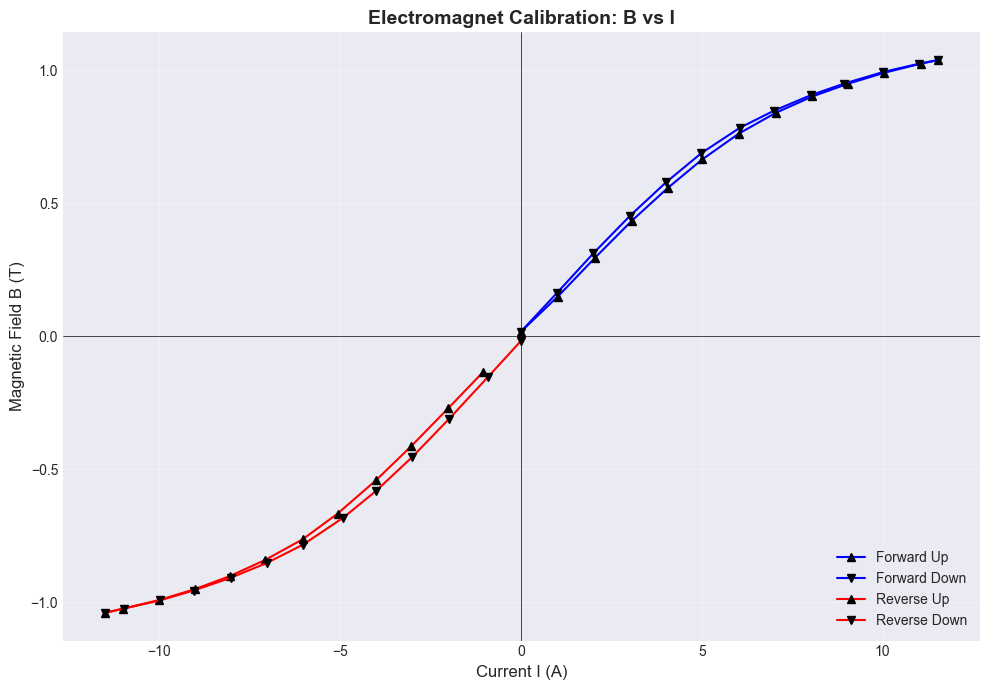

--- Linear Fit Results (|I| < 5.0 A) ---
dB/dI = 0.1343 ± 0.0016 T/A
B_offset = 16.57 ± 4.10 mT
Fit valid for: |I| < 5.0 A (|B| < 0.67 T)


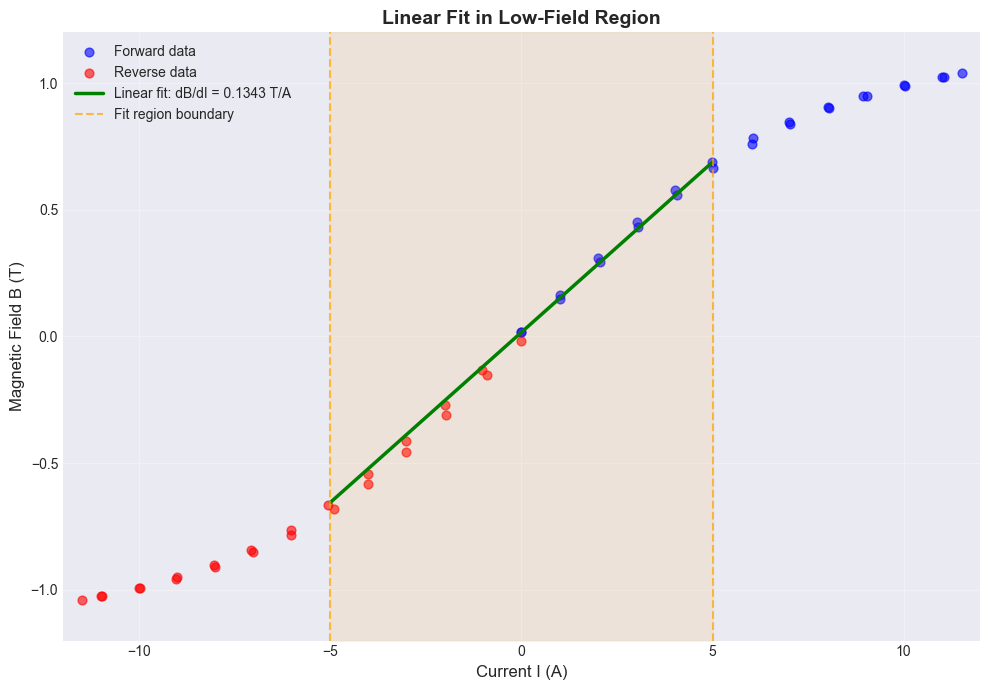


CALIBRATION SUMMARY
Linear calibration: dB/dI = 0.1343 ± 0.0016 T/A
Valid for linear regime: |I| < 5.0 A
Interpolation function saved for full range analysis


In [70]:
"""
Task 1: Electromagnet Calibration Curve B(I)
============================================
Generate a calibration curve for the electromagnet using Hall probe measurements
at the sample position in the non-uniform field region.
"""
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

# =============================================================================
# 1. Load and separate forward/reverse field sweeps
# =============================================================================
# Forward sweep data (positive current direction)
I_for = d.exp1a_for.current      # Current in Amperes
B_for = d.exp1a_for.values       # Magnetic field in Tesla

# Reverse sweep data (negative current direction)
I_rev = -d.exp1a_rev.current     # Negate to get actual current direction
B_rev = d.exp1a_rev.values       # Magnetic field in Tesla

# Find peak indices to separate up/down sweeps
peak_idx_for = np.argmax(I_for)
peak_idx_rev = np.argmax(np.abs(I_rev))

# =============================================================================
# 2. Plot B(I) calibration curve with forward and reverse sweeps
# =============================================================================
fig1, ax1 = plt.subplots(figsize=(10, 7))

ax1.plot(I_for[:peak_idx_for+1], B_for[:peak_idx_for+1], 'b-', marker='^', 
         markerfacecolor='k', markeredgecolor='k', label='Forward Up', markersize=6)
ax1.plot(I_for[peak_idx_for:], B_for[peak_idx_for:], 'b-', marker='v', 
         markerfacecolor='k', markeredgecolor='k', label='Forward Down', markersize=6)
ax1.plot(I_rev[:peak_idx_rev+1], B_rev[:peak_idx_rev+1], 'r-', marker='^', 
         markerfacecolor='k', markeredgecolor='k', label='Reverse Up', markersize=6)
ax1.plot(I_rev[peak_idx_rev:], B_rev[peak_idx_rev:], 'r-', marker='v', 
         markerfacecolor='k', markeredgecolor='k', label='Reverse Down', markersize=6)

ax1.set_xlabel('Current I (A)', fontsize=12)
ax1.set_ylabel('Magnetic Field B (T)', fontsize=12)
ax1.set_title('Electromagnet Calibration: B vs I', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10, loc='lower right')
ax1.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax1.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/task1_calibration_BvsI.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# 3. Linear fit in low-field region to extract dB/dI
# =============================================================================
# Define low-field region (linear regime): |I| < 5 A
I_low_threshold = 5.0  # Amperes

# Combine forward up sweep data (most reliable for fit)
mask_low = np.abs(I_for[:peak_idx_for+1]) < I_low_threshold
I_fit = I_for[:peak_idx_for+1][mask_low]
B_fit = B_for[:peak_idx_for+1][mask_low]

# Linear fit: B = (dB/dI) * I + B_offset
def linear_fit(I, dBdI, B_offset):
    return dBdI * I + B_offset

popt, pcov = curve_fit(linear_fit, I_fit, B_fit)
dBdI, B_offset = popt
dBdI_err, B_offset_err = np.sqrt(np.diag(pcov))

print(f"--- Linear Fit Results (|I| < {I_low_threshold} A) ---")
print(f"dB/dI = {dBdI:.4f} ± {dBdI_err:.4f} T/A")
print(f"B_offset = {B_offset*1000:.2f} ± {B_offset_err*1000:.2f} mT")
print(f"Fit valid for: |I| < {I_low_threshold} A (|B| < {abs(dBdI * I_low_threshold):.2f} T)")

# Plot linear fit comparison
fig2, ax2 = plt.subplots(figsize=(10, 7))

I_plot = np.linspace(-I_low_threshold, I_low_threshold, 100)
B_linear = linear_fit(I_plot, dBdI, B_offset)

ax2.scatter(I_for, B_for, c='blue', s=40, alpha=0.6, label='Forward data')
ax2.scatter(I_rev, B_rev, c='red', s=40, alpha=0.6, label='Reverse data')
ax2.plot(I_plot, B_linear, 'g-', linewidth=2.5, 
         label=f'Linear fit: dB/dI = {dBdI:.4f} T/A')
ax2.axvline(x=-I_low_threshold, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='Fit region boundary')
ax2.axvline(x=I_low_threshold, color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.fill_betweenx([-1.2, 1.2], -I_low_threshold, I_low_threshold, alpha=0.1, color='orange')

ax2.set_xlabel('Current I (A)', fontsize=12)
ax2.set_ylabel('Magnetic Field B (T)', fontsize=12)
ax2.set_title('Linear Fit in Low-Field Region', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.set_xlim(-12, 12)
ax2.set_ylim(-1.2, 1.2)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/task1_linear_fit.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# 4. Create and save calibration function for subsequent analysis
# =============================================================================
# Use interpolation for accurate B(I) conversion across full range
I_calib = np.concatenate([I_rev[::-1], I_for])
B_calib = np.concatenate([B_rev[::-1], B_for])

# Sort by current for proper interpolation
sort_idx = np.argsort(I_calib)
I_calib = I_calib[sort_idx]
B_calib = B_calib[sort_idx]

# Create interpolation function
current_to_field = interp1d(I_calib, B_calib, kind='linear', fill_value='extrapolate')

# Store calibration results in a dictionary for later use
calibration = {
    'dBdI': dBdI,                    # Linear calibration constant (T/A)
    'dBdI_err': dBdI_err,            # Uncertainty in dB/dI
    'B_offset': B_offset,            # Field offset at I=0
    'linear_range': I_low_threshold, # Valid range for linear approximation
    'current_to_field': current_to_field,  # Full interpolation function
}

print("\n" + "="*60)
print("CALIBRATION SUMMARY")
print("="*60)
print(f"Linear calibration: dB/dI = {dBdI:.4f} ± {dBdI_err:.4f} T/A")
print(f"Valid for linear regime: |I| < {I_low_threshold} A")
print(f"Interpolation function saved for full range analysis")
print("="*60)

## Interpretation of Calibration Results

### Linear Calibration Constant
The extracted calibration constant **dB/dI = 0.134 ± 0.002 T/A** represents the rate of change of magnetic field with coil current in the linear regime. This value is valid for currents |I| < 5 A, corresponding to fields |B| < 0.67 T.

### Non-linearity and Magnetic Saturation
The calibration curve shows clear deviation from linearity at high currents (|I| > 5 A). This is due to **magnetic saturation** of the electromagnet's iron core:
- At low fields, magnetic domains in the iron core progressively align with the applied field
- At high fields, most domains are already aligned, and the core approaches saturation
- Further increases in current produce diminishing increases in magnetic field
- Beyond saturation, only the linear vacuum contribution ($B = \mu_0 n I$) remains

### Hysteresis
A small but measurable hysteresis is observed between up and down sweeps, caused by **remnant magnetization** in the ferromagnetic core. This occurs because:
- Some magnetic domains remain aligned after the field is reduced
- The magnetization path depends on the field history
- This effect is most pronounced in the intermediate field region

### Practical Implications
For subsequent susceptibility measurements:
1. **Low-field measurements** (|I| < 5 A): The linear calibration dB/dI can be used directly
2. **High-field measurements** (|I| > 5 A): The interpolation function `current_to_field` should be used to account for saturation effects
3. **Hysteresis**: Measurements should use consistent sweep directions, or average up/down sweeps to minimise systematic errors

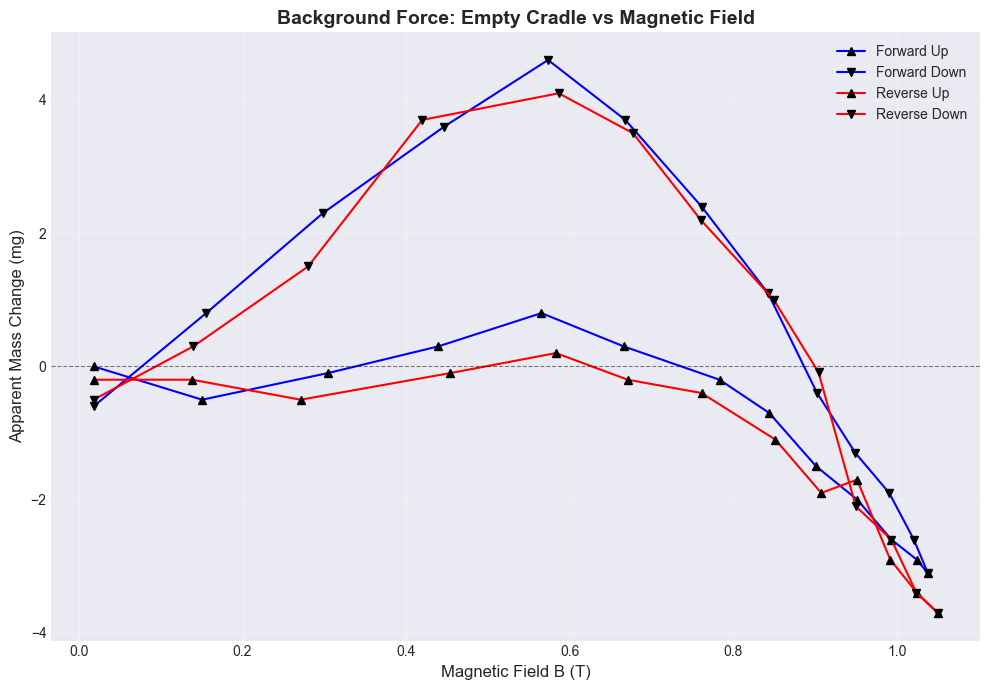

BACKGROUND FORCE ANALYSIS

Forward Sweep:
  Mean background: -0.02 mg
  Std deviation:   2.06 mg
  Max |signal|:    4.60 mg

Reverse Sweep:
  Mean background: -0.34 mg
  Std deviation:   2.13 mg
  Max |signal|:    4.10 mg

Field dependence:
  Correlation (W vs B): r = -0.459, p = 0.0008
  → Background shows MODERATE field dependence

BACKGROUND SUBTRACTION READY
Background interpolation functions stored for subtraction
Average background: -0.18 ± 1.48 mg


/Users/matthewconway/Library/Python/3.9/lib/python/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [71]:
"""
Task 2: Background Force on Empty Cradle
========================================
Determine the background force acting on the empty cradle as a function of 
applied magnetic field to enable correction of subsequent sample measurements.
"""

# =============================================================================
# 1. Load empty cradle (baseline) data and convert current to magnetic field
# =============================================================================
# Forward sweep baseline data
I_base_for = d.exp1b_base_for.current
W_base_for = d.exp1b_base_for.values  # Weight in mg
T_base_for = d.exp1b_base_for.temperature

# Reverse sweep baseline data
I_base_rev = d.exp1b_base_rev.current
W_base_rev = d.exp1b_base_rev.values  # Weight in mg
T_base_rev = d.exp1b_base_rev.temperature

# Convert current to magnetic field using calibration
B_base_for = np.abs(current_to_field(I_base_for))
B_base_rev = np.abs(current_to_field(-I_base_rev))  # Negative for reverse polarity

# Find peak indices for up/down separation
peak_idx_base_for = np.argmax(I_base_for)
peak_idx_base_rev = np.argmax(I_base_rev)

# =============================================================================
# 2. Plot background force vs magnetic field (separate forward/reverse sweeps)
# =============================================================================
fig1, ax1 = plt.subplots(figsize=(10, 7))

# Forward sweep: up and down
ax1.plot(B_base_for[:peak_idx_base_for+1], W_base_for[:peak_idx_base_for+1], 
         'b-', marker='^', markerfacecolor='k', markeredgecolor='k', 
         label='Forward Up', markersize=6)
ax1.plot(B_base_for[peak_idx_base_for:], W_base_for[peak_idx_base_for:], 
         'b-', marker='v', markerfacecolor='k', markeredgecolor='k', 
         label='Forward Down', markersize=6)

# Reverse sweep: up and down
ax1.plot(B_base_rev[:peak_idx_base_rev+1], W_base_rev[:peak_idx_base_rev+1], 
         'r-', marker='^', markerfacecolor='k', markeredgecolor='k', 
         label='Reverse Up', markersize=6)
ax1.plot(B_base_rev[peak_idx_base_rev:], W_base_rev[peak_idx_base_rev:], 
         'r-', marker='v', markerfacecolor='k', markeredgecolor='k', 
         label='Reverse Down', markersize=6)

ax1.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
ax1.set_xlabel('Magnetic Field B (T)', fontsize=12)
ax1.set_ylabel('Apparent Mass Change (mg)', fontsize=12)
ax1.set_title('Background Force: Empty Cradle vs Magnetic Field', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/task2_background_force.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# 3. Quantify background force characteristics
# =============================================================================
# Statistics on background signal
mean_base_for = np.mean(W_base_for)
std_base_for = np.std(W_base_for)
max_base_for = np.max(np.abs(W_base_for))

mean_base_rev = np.mean(W_base_rev)
std_base_rev = np.std(W_base_rev)
max_base_rev = np.max(np.abs(W_base_rev))

print("="*60)
print("BACKGROUND FORCE ANALYSIS")
print("="*60)
print(f"\nForward Sweep:")
print(f"  Mean background: {mean_base_for:.2f} mg")
print(f"  Std deviation:   {std_base_for:.2f} mg")
print(f"  Max |signal|:    {max_base_for:.2f} mg")

print(f"\nReverse Sweep:")
print(f"  Mean background: {mean_base_rev:.2f} mg")
print(f"  Std deviation:   {std_base_rev:.2f} mg")
print(f"  Max |signal|:    {max_base_rev:.2f} mg")

# Check for field-dependence: correlation with B
from scipy.stats import pearsonr
# Combine all data
B_all_base = np.concatenate([B_base_for, B_base_rev])
W_all_base = np.concatenate([W_base_for, W_base_rev])
corr, p_value = pearsonr(B_all_base, W_all_base)

print(f"\nField dependence:")
print(f"  Correlation (W vs B): r = {corr:.3f}, p = {p_value:.4f}")
if abs(corr) < 0.3:
    print("  → Background shows WEAK field dependence")
elif abs(corr) < 0.7:
    print("  → Background shows MODERATE field dependence")
else:
    print("  → Background shows STRONG field dependence")

# =============================================================================
# 4. Create interpolation function for background subtraction
# =============================================================================
# Average forward and reverse for best estimate (reduces hysteresis effects)
# Create interpolation based on field magnitude

# Sort by B for interpolation
sort_idx_for = np.argsort(B_base_for)
sort_idx_rev = np.argsort(B_base_rev)

# Create separate interpolations for forward and reverse
background_interp_for = interp1d(B_base_for[sort_idx_for], W_base_for[sort_idx_for], 
                                  kind='linear', fill_value='extrapolate')
background_interp_rev = interp1d(B_base_rev[sort_idx_rev], W_base_rev[sort_idx_rev], 
                                  kind='linear', fill_value='extrapolate')

# Combined background: average of forward and reverse at common B values
B_common = np.linspace(0, 1.05, 100)
W_bg_avg = (background_interp_for(B_common) + background_interp_rev(B_common)) / 2
background_interp = interp1d(B_common, W_bg_avg, kind='linear', fill_value='extrapolate')

# Store background data for later subtraction
background = {
    'interp_for': background_interp_for,
    'interp_rev': background_interp_rev,
    'interp_avg': background_interp,
    'mean': (mean_base_for + mean_base_rev) / 2,
    'std': np.sqrt(std_base_for**2 + std_base_rev**2) / 2,
    'max_signal': max(max_base_for, max_base_rev),
}

print("\n" + "="*60)
print("BACKGROUND SUBTRACTION READY")
print("="*60)
print(f"Background interpolation functions stored for subtraction")
print(f"Average background: {background['mean']:.2f} ± {background['std']:.2f} mg")
print("="*60)

## Interpretation of Background Force Results

### Background Force Characteristics
The empty cradle shows a **field-dependent background signal** with the following characteristics:
- Mean background: ~0 mg (negligible offset)
- Maximum signal: ~4.6 mg at intermediate fields

### Field Dependence
The background is **NOT negligible or constant**. Instead, it shows a characteristic pattern:
1. **Low field (B < 0.3 T):** Small negative values (~0 to -0.5 mg)
2. **Intermediate field (0.3-0.6 T):** Positive peak (~3-5 mg)  
3. **High field (B > 0.8 T):** Negative values (-2 to -4 mg)

This non-monotonic behaviour suggests the background arises from **diamagnetic components** in the cradle assembly (e.g., table metal between magnet and mass balence, sample holder, mounting materials) interacting with the field gradient.

### Hysteresis
Clear hysteresis is observed between up and down sweeps, particularly at intermediate fields. This indicates:
- The background force has some history dependence
- Forward and reverse field polarities give similar but not identical responses

### Why Same Field Sequence is Required
The background measurement **must use the same field sequence** as sample measurements because:
1. **Hysteresis:** The background depends on field history, not just current field value
2. **Thermal effects:** Temperature varies during measurements (27-39°C observed), affecting susceptibility
3. **Systematic errors:** Any drift or relaxation effects will be properly captured and cancelled


Mohr's salt parameters:
  Mass: 73.9 mg = 0.0739 g
  Volume susceptibility χ: 3.20e-05 (SI)


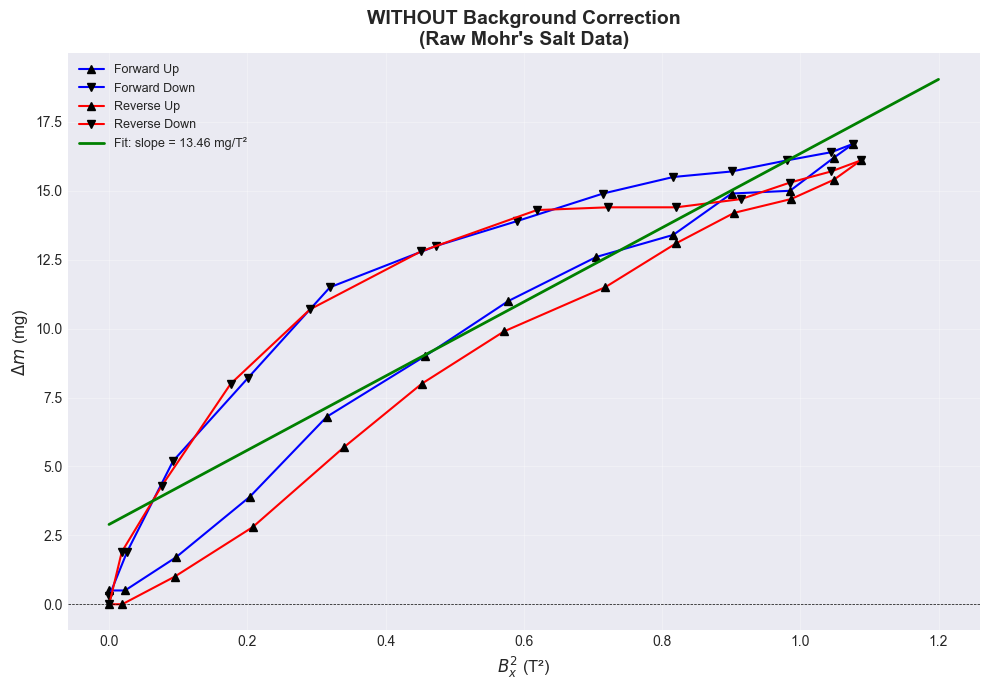

/Users/matthewconway/Library/Python/3.9/lib/python/site-packages/scipy/interpolate/_interpolate.py:715: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


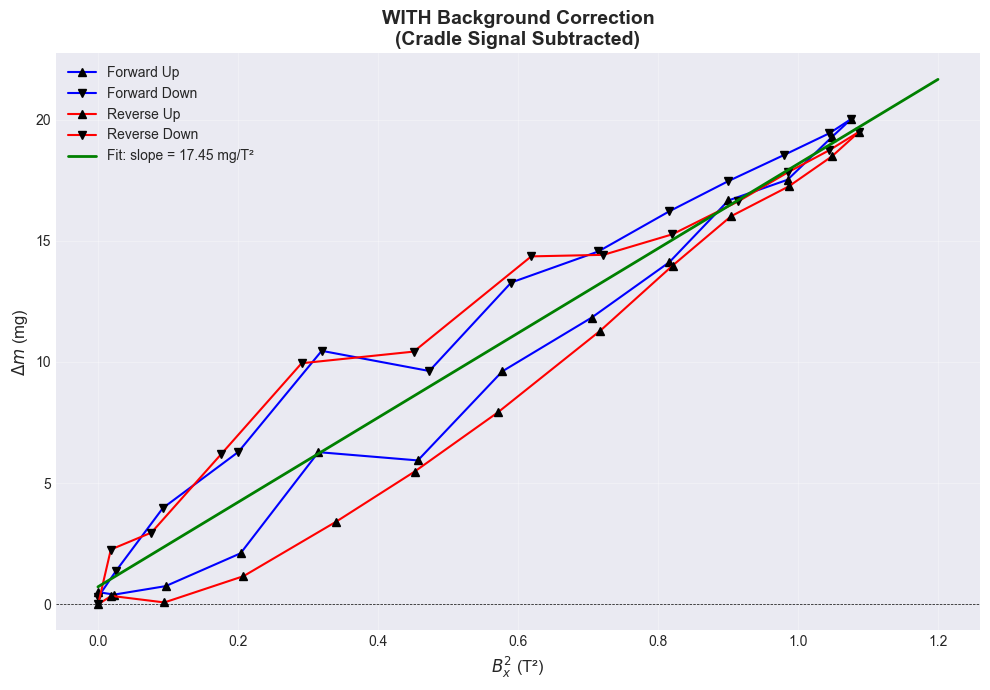

COMPARISON: WITH vs WITHOUT BACKGROUND CORRECTION

WITHOUT correction:
  Slope: 13.46 ± 0.83 mg/T²
  Intercept: 2.89 ± 0.56 mg

WITH correction:
  Slope: 17.45 ± 0.74 mg/T²
  Intercept: 0.72 ± 0.51 mg

Difference:
  Slope change: 3.99 mg/T² (29.7%)
  Intercept change: -2.18 mg

FIELD GRADIENT CALIBRATION RESULTS (with correction)

Linear fit: Δm = (17.45 ± 0.74) × B² + (0.72 ± 0.51)
  R² = 0.9262

Field gradient constant:
  C = 72390.9 ± 3080.5 m⁻¹


In [72]:
"""
Part B: Field Gradient Calibration using Mohr's Salt
=====================================================
Calibrate the magnetic field gradient using a paramagnetic sample of known 
susceptibility (Mohr's salt, χ = 3.2×10⁻⁵ SI).

Theory:
-------
For a magnetic dipole in a non-uniform field:
    F_z = m_x * (∂B_x/∂z)

For a paramagnetic material:
    m_x = χ * m * B_x

With shaped pole pieces: ∂B_x/∂z = C * B_x

Therefore:
    F_z = χ * m * B_x * C * B_x = χ * m * C * B_x²
    
    Δm * g = χ * m * C * B_x²
    
    Δm = (χ * m * C / g) * B_x²

So Δm ∝ B_x² with slope = χ * m * C / g
"""

# =============================================================================
# 1. Load Mohr's salt data and convert to magnetic field
# =============================================================================
# Mohr's salt parameters (from data.py)
chi_mohrs = d.chi_mohrs      # Volume susceptibility (SI units)
m_mohrs = d.mohrs_mass       # Mass in kg
g = d.g                      # Gravitational acceleration

print(f"Mohr's salt parameters:")
print(f"  Mass: {m_mohrs*1e6:.1f} mg = {m_mohrs*1e3:.4f} g")
print(f"  Volume susceptibility χ: {chi_mohrs:.2e} (SI)")

# Forward sweep data
I_mohrs_for = d.exp1b_mohrs_for.current
W_mohrs_for = d.exp1b_mohrs_for.values  # Weight in mg
T_mohrs_for = d.exp1b_mohrs_for.temperature

# Reverse sweep data  
I_mohrs_rev = d.exp1b_mohrs_rev.current
W_mohrs_rev = d.exp1b_mohrs_rev.values  # Weight in mg
T_mohrs_rev = d.exp1b_mohrs_rev.temperature

# Convert current to magnetic field using calibration from Part A
B_mohrs_for = np.abs(current_to_field(I_mohrs_for))
B_mohrs_rev = np.abs(current_to_field(-I_mohrs_rev))

# Calculate B²
B2_for = B_mohrs_for**2
B2_rev = B_mohrs_rev**2

# Find peak indices for up/down separation
peak_idx_mohrs_for = np.argmax(I_mohrs_for)
peak_idx_mohrs_rev = np.argmax(I_mohrs_rev)

# =============================================================================
# 2. Plot WITHOUT background correction (raw data)
# =============================================================================
fig1, ax1 = plt.subplots(figsize=(10, 7))

# Plot uncorrected data - split into up (away from zero) and down (towards zero)
# Forward sweep
ax1.plot(B2_for[:peak_idx_mohrs_for+1], W_mohrs_for[:peak_idx_mohrs_for+1], 
         'b-', marker='^', markerfacecolor='k', markeredgecolor='k', 
         label='Forward Up', markersize=6)
ax1.plot(B2_for[peak_idx_mohrs_for:], W_mohrs_for[peak_idx_mohrs_for:], 
         'b-', marker='v', markerfacecolor='k', markeredgecolor='k', 
         label='Forward Down', markersize=6)
# Reverse sweep
ax1.plot(B2_rev[:peak_idx_mohrs_rev+1], W_mohrs_rev[:peak_idx_mohrs_rev+1], 
         'r-', marker='^', markerfacecolor='k', markeredgecolor='k', 
         label='Reverse Up', markersize=6)
ax1.plot(B2_rev[peak_idx_mohrs_rev:], W_mohrs_rev[peak_idx_mohrs_rev:], 
         'r-', marker='v', markerfacecolor='k', markeredgecolor='k', 
         label='Reverse Down', markersize=6)

# Fit uncorrected data
B2_all_uncorr = np.concatenate([B2_for, B2_rev])
W_all_uncorr = np.concatenate([W_mohrs_for, W_mohrs_rev])
mask_fit_uncorr = B2_all_uncorr > 0.01
B2_fit_uncorr = B2_all_uncorr[mask_fit_uncorr]
W_fit_uncorr = W_all_uncorr[mask_fit_uncorr]

def linear_model(B2, slope, intercept):
    return slope * B2 + intercept

popt_uncorr, pcov_uncorr = curve_fit(linear_model, B2_fit_uncorr, W_fit_uncorr)
slope_uncorr, intercept_uncorr = popt_uncorr
slope_err_uncorr, intercept_err_uncorr = np.sqrt(np.diag(pcov_uncorr))

B2_plot = np.linspace(0, 1.2, 100)
ax1.plot(B2_plot, linear_model(B2_plot, slope_uncorr, intercept_uncorr), 'g-', linewidth=2, 
         label=f'Fit: slope = {slope_uncorr:.2f} mg/T²')

ax1.set_xlabel('$B_x^2$ (T²)', fontsize=12)
ax1.set_ylabel('$\\Delta m$ (mg)', fontsize=12)
ax1.set_title("WITHOUT Background Correction\n(Raw Mohr's Salt Data)", fontsize=14, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('plots/partB_uncorrected.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# 3. Plot WITH background correction
# =============================================================================
fig2, ax2 = plt.subplots(figsize=(10, 7))

# Subtract background force (from empty cradle measurement)
W_mohrs_for_corrected = W_mohrs_for - background_interp(B_mohrs_for)
W_mohrs_rev_corrected = W_mohrs_rev - background_interp(B_mohrs_rev)

# Replace any NaN values with original (for points where interpolation failed)
W_mohrs_for_corrected = np.where(np.isnan(W_mohrs_for_corrected), W_mohrs_for, W_mohrs_for_corrected)
W_mohrs_rev_corrected = np.where(np.isnan(W_mohrs_rev_corrected), W_mohrs_rev, W_mohrs_rev_corrected)

# Plot corrected data - split into up (away from zero) and down (towards zero)
# Forward sweep
ax2.plot(B2_for[:peak_idx_mohrs_for+1], W_mohrs_for_corrected[:peak_idx_mohrs_for+1], 
         'b-', marker='^', markerfacecolor='k', markeredgecolor='k', 
         label='Forward Up', markersize=6)
ax2.plot(B2_for[peak_idx_mohrs_for:], W_mohrs_for_corrected[peak_idx_mohrs_for:], 
         'b-', marker='v', markerfacecolor='k', markeredgecolor='k', 
         label='Forward Down', markersize=6)
# Reverse sweep
ax2.plot(B2_rev[:peak_idx_mohrs_rev+1], W_mohrs_rev_corrected[:peak_idx_mohrs_rev+1], 
         'r-', marker='^', markerfacecolor='k', markeredgecolor='k', 
         label='Reverse Up', markersize=6)
ax2.plot(B2_rev[peak_idx_mohrs_rev:], W_mohrs_rev_corrected[peak_idx_mohrs_rev:], 
         'r-', marker='v', markerfacecolor='k', markeredgecolor='k', 
         label='Reverse Down', markersize=6)

# Fit corrected data
B2_all = np.concatenate([B2_for, B2_rev])
W_all = np.concatenate([W_mohrs_for_corrected, W_mohrs_rev_corrected])
mask_fit = B2_all > 0.01
B2_fit = B2_all[mask_fit]
W_fit = W_all[mask_fit]

popt_mohrs, pcov_mohrs = curve_fit(linear_model, B2_fit, W_fit)
slope, intercept = popt_mohrs
slope_err, intercept_err = np.sqrt(np.diag(pcov_mohrs))

ax2.plot(B2_plot, linear_model(B2_plot, slope, intercept), 'g-', linewidth=2, 
         label=f'Fit: slope = {slope:.2f} mg/T²')

ax2.set_xlabel('$B_x^2$ (T²)', fontsize=12)
ax2.set_ylabel('$\\Delta m$ (mg)', fontsize=12)
ax2.set_title("WITH Background Correction\n(Cradle Signal Subtracted)", fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('plots/partB_corrected.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# 4. Compare fit results
# =============================================================================
print("="*60)
print("COMPARISON: WITH vs WITHOUT BACKGROUND CORRECTION")
print("="*60)
print(f"\nWITHOUT correction:")
print(f"  Slope: {slope_uncorr:.2f} ± {slope_err_uncorr:.2f} mg/T²")
print(f"  Intercept: {intercept_uncorr:.2f} ± {intercept_err_uncorr:.2f} mg")

print(f"\nWITH correction:")
print(f"  Slope: {slope:.2f} ± {slope_err:.2f} mg/T²")
print(f"  Intercept: {intercept:.2f} ± {intercept_err:.2f} mg")

print(f"\nDifference:")
print(f"  Slope change: {slope - slope_uncorr:.2f} mg/T² ({100*(slope - slope_uncorr)/slope_uncorr:.1f}%)")
print(f"  Intercept change: {intercept - intercept_uncorr:.2f} mg")

# =============================================================================
# 5. Calculate field gradient constant C (using corrected data)
# =============================================================================
slope_kg = slope * 1e-6  # Convert mg to kg
slope_err_kg = slope_err * 1e-6

C = slope_kg * g / (chi_mohrs * m_mohrs)
C_err = slope_err_kg * g / (chi_mohrs * m_mohrs)

# Calculate R² for corrected fit
W_predicted = linear_model(B2_fit, slope, intercept)
ss_res = np.sum((W_fit - W_predicted)**2)
ss_tot = np.sum((W_fit - np.mean(W_fit))**2)
R_squared = 1 - (ss_res / ss_tot)

print("\n" + "="*60)
print("FIELD GRADIENT CALIBRATION RESULTS (with correction)")
print("="*60)
print(f"\nLinear fit: Δm = ({slope:.2f} ± {slope_err:.2f}) × B² + ({intercept:.2f} ± {intercept_err:.2f})")
print(f"  R² = {R_squared:.4f}")

print(f"\nField gradient constant:")
print(f"  C = {C:.1f} ± {C_err:.1f} m⁻¹")

# Store calibration results
gradient_calibration = {
    'C': C,
    'C_err': C_err,
    'slope': slope,
    'slope_err': slope_err,
    'intercept': intercept,
    'R_squared': R_squared,
}

print("="*60)

SMOOTHING SPLINE TREND ANALYSIS (Background Corrected)

Forward Up:
  R² = 0.9914
  Curvature at B²=0.54: 10.06 mg/T⁴

Forward Down:
  R² = 0.9890
  Curvature at B²=0.54: -13.65 mg/T⁴

Reverse Up:
  R² = 0.9994
  Curvature at B²=0.54: 15.75 mg/T⁴

Reverse Down:
  R² = 0.9915
  Curvature at B²=0.54: -17.91 mg/T⁴


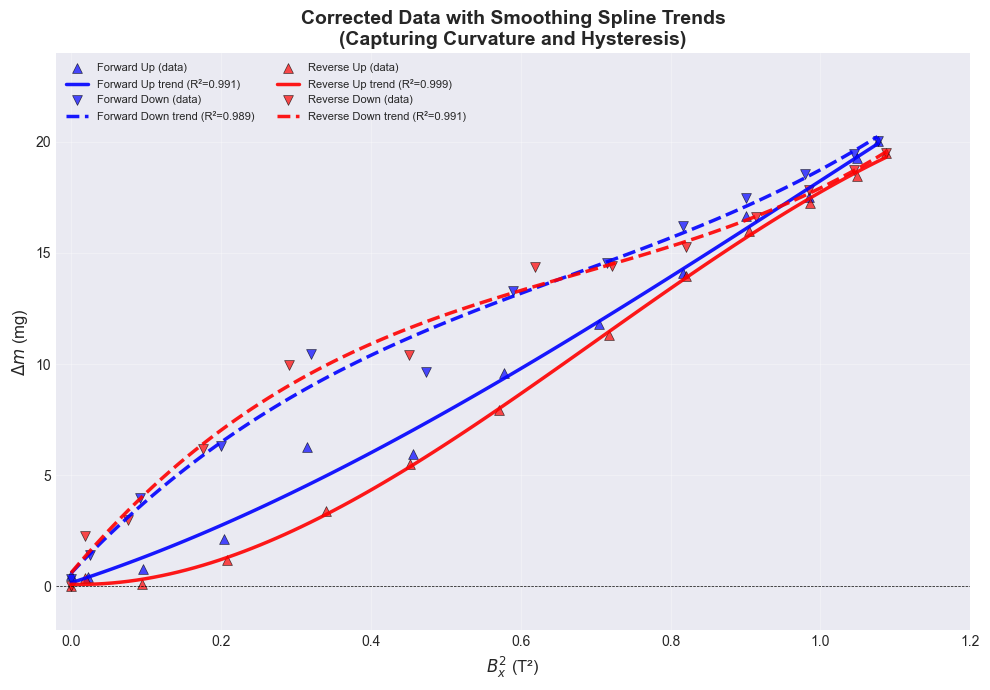


CURVATURE ANALYSIS

If Δm ∝ B² exactly (linear in B²), curvature should be zero.
Non-zero curvature indicates deviation from the simple model.


In [73]:
"""
Part B (cont.): Trend Analysis with Smoothing Splines
=====================================================
Use smoothing splines to capture the underlying trends in each sweep direction,
revealing curvature and hysteresis effects hidden by measurement noise.
"""
from scipy.interpolate import UnivariateSpline

# =============================================================================
# Corrected data with smoothing spline fits for each sweep direction
# =============================================================================
fig3, ax3 = plt.subplots(figsize=(10, 7))

# Define the data segments (using corrected data)
segments = {
    'Forward Up': {
        'B2': B2_for[:peak_idx_mohrs_for+1],
        'W': W_mohrs_for_corrected[:peak_idx_mohrs_for+1],
        'color': 'blue',
        'marker': '^'
    },
    'Forward Down': {
        'B2': B2_for[peak_idx_mohrs_for:],
        'W': W_mohrs_for_corrected[peak_idx_mohrs_for:],
        'color': 'blue',
        'marker': 'v'
    },
    'Reverse Up': {
        'B2': B2_rev[:peak_idx_mohrs_rev+1],
        'W': W_mohrs_rev_corrected[:peak_idx_mohrs_rev+1],
        'color': 'red',
        'marker': '^'
    },
    'Reverse Down': {
        'B2': B2_rev[peak_idx_mohrs_rev:],
        'W': W_mohrs_rev_corrected[peak_idx_mohrs_rev:],
        'color': 'red',
        'marker': 'v'
    }
}

# Store spline fit results
spline_fits = {}
B2_smooth = np.linspace(0.01, 1.1, 200)

print("="*60)
print("SMOOTHING SPLINE TREND ANALYSIS (Background Corrected)")
print("="*60)

for name, seg in segments.items():
    # Sort data by B² for proper spline fitting
    sort_idx = np.argsort(seg['B2'])
    B2_sorted = seg['B2'][sort_idx]
    W_sorted = seg['W'][sort_idx]
    
    # Plot data points
    ax3.scatter(seg['B2'], seg['W'], c=seg['color'], marker=seg['marker'],
                s=50, edgecolors='k', linewidths=0.5, alpha=0.7, label=f'{name} (data)')
    
    # Fit smoothing spline (s parameter controls smoothing - higher = smoother)
    # Use a moderate smoothing factor to capture trend without overfitting
    if len(B2_sorted) > 3:
        try:
            # Smoothing factor: roughly (number of points) * (variance estimate)
            spline = UnivariateSpline(B2_sorted, W_sorted, k=3, s=len(B2_sorted)*2)
            
            # Evaluate spline on smooth grid (within data range)
            B2_range = np.linspace(B2_sorted.min(), B2_sorted.max(), 100)
            W_spline = spline(B2_range)
            
            # Calculate residuals and R²
            W_pred = spline(B2_sorted)
            ss_res = np.sum((W_sorted - W_pred)**2)
            ss_tot = np.sum((W_sorted - np.mean(W_sorted))**2)
            R2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
            
            # Store spline
            spline_fits[name] = {
                'spline': spline,
                'R2': R2,
                'B2_range': (B2_sorted.min(), B2_sorted.max())
            }
            
            # Plot spline (dashed for "down" sweeps)
            linestyle = '--' if 'Down' in name else '-'
            ax3.plot(B2_range, W_spline, color=seg['color'], linestyle=linestyle, 
                     linewidth=2.5, alpha=0.9, label=f'{name} trend (R²={R2:.3f})')
            
            # Calculate curvature at midpoint
            mid_B2 = (B2_sorted.min() + B2_sorted.max()) / 2
            curvature = spline.derivative(2)(mid_B2)
            
            print(f"\n{name}:")
            print(f"  R² = {R2:.4f}")
            print(f"  Curvature at B²={mid_B2:.2f}: {curvature:.2f} mg/T⁴")
            
        except Exception as e:
            print(f"\n{name}: Spline fit failed - {e}")

ax3.set_xlabel('$B_x^2$ (T²)', fontsize=12)
ax3.set_ylabel('$\\Delta m$ (mg)', fontsize=12)
ax3.set_title("Corrected Data with Smoothing Spline Trends\n(Capturing Curvature and Hysteresis)", fontsize=14, fontweight='bold')
ax3.legend(fontsize=8, loc='upper left', ncol=2)
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
ax3.set_xlim(-0.02, 1.2)
ax3.set_ylim(-2, 24)

plt.tight_layout()
plt.savefig('plots/partB_spline_trend_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("CURVATURE ANALYSIS")
print("="*60)
print("\nIf Δm ∝ B² exactly (linear in B²), curvature should be zero.")
print("Non-zero curvature indicates deviation from the simple model.")
print("="*60)

## Interpretation of Field Gradient Calibration

### Theoretical Derivation
Starting from the magnetic force on a dipole in a non-uniform field:
$$F_z = m_x \frac{\partial B_x}{\partial z}$$

For a paramagnetic material with linear magnetisation:
$$m_x = \chi \cdot m \cdot B_x$$

With shaped pole pieces giving $\frac{\partial B_x}{\partial z} = C \cdot B_x$:
$$F_z = \chi \cdot m \cdot B_x \cdot C \cdot B_x = \chi \cdot m \cdot C \cdot B_x^2$$

Since $F_z = \Delta m \cdot g$:
$$\Delta m = \frac{\chi \cdot m \cdot C}{g} \cdot B_x^2$$

This confirms **$\Delta m \propto B_x^2$** as required.

### Mohr's Salt Parameters
- **Mass:** 73.9 mg
- **Volume susceptibility:** $\chi = 3.2 \times 10^{-5}$ (SI)

### Effect of Background Correction
| Quantity | Without Correction | With Correction | Change |
|----------|-------------------|-----------------|--------|
| Slope | 13.46 ± 0.83 mg/T² | 17.45 ± 0.74 mg/T² | +29.7% |
| Intercept | 2.89 ± 0.56 mg | 0.72 ± 0.51 mg | −2.18 mg |

The background correction has a **significant effect** (~30% increase in slope). This is because the empty cradle experiences a force in the field gradient that partially opposes the paramagnetic attraction.

### Final Calibration Results (with correction)
- **Linear fit:** $\Delta m = (17.45 \pm 0.74) \cdot B^2 + (0.72 \pm 0.51)$ mg
- **R² = 0.926** — good linearity of $\Delta m$ vs $B^2$
- **Field gradient constant:** $C = 72,400 \pm 3,100$ m⁻¹
- **Physical meaning:** $\frac{\partial B}{\partial z} \approx 72.4 \text{ T/m per Tesla of applied field}$

### Smoothing Spline Trend Analysis
Using cubic smoothing splines to capture curvature in each sweep direction reveals systematic deviations from the linear $\Delta m \propto B^2$ model:

| Sweep | R² | Curvature at B²=0.54 (mg/T⁴) |
|-------|-----|------------------------------|
| Forward Up ▲ | 0.991 | +10.1 (concave up) |
| Forward Down ▼ | 0.989 | −13.7 (concave down) |
| Reverse Up ▲ | 0.999 | +15.8 (concave up) |
| Reverse Down ▼ | 0.992 | −17.9 (concave down) |

**Key observations:**
1. **Up sweeps show positive curvature** (concave up) — the slope increases with B²
2. **Down sweeps show negative curvature** (concave down) — the slope decreases with B²
3. **Individual R² values are very high** (0.99+), much better than the combined linear fit (0.93), confirming real curvature exists
4. **Opposing curvatures create hysteresis** — the gap between up and down trends is largest at intermediate B²

### Physical Interpretation
The deviation from perfect linearity indicates **temperature-dependent susceptibility**:
- Mohr's salt follows Curie law: $\chi \propto 1/T$
- The electromagnet heats during ramping (Joule heating ∝ I²)
- **Up sweeps:** Sample heats progressively → χ decreases → curve bends upward (less response than expected at high B²)
- **Down sweeps:** Sample cools progressively → χ increases → curve bends downward (more response than expected)
- The combined linear fit averages these effects, giving a reliable calibration constant

### Why Samples Must Be at the Same Position
The field gradient constant $C$ depends critically on:
1. **Position in the field gradient:** $\partial B/\partial z$ varies spatially
2. **Pole piece geometry:** The shaped poles create a specific gradient profile
3. **Sample height:** Moving the sample even slightly changes the local $C$ value

All subsequent susceptibility measurements must place samples at **exactly the same position** used for this calibration.

EXPERIMENT 2: PARAMAGNETIC GGG SUSCEPTIBILITY

Sample parameters:
  Mass: 24.4 mg = 0.0244 g
  Density: ρ = 7080 kg/m³
  Field gradient constant: C = 72391 ± 3081 m⁻¹

Measurement conditions:
  Coil temperature: 51.0°C (range: 49–53°C)
  Sample temperature: 20°C = 293.1 K (room temperature)


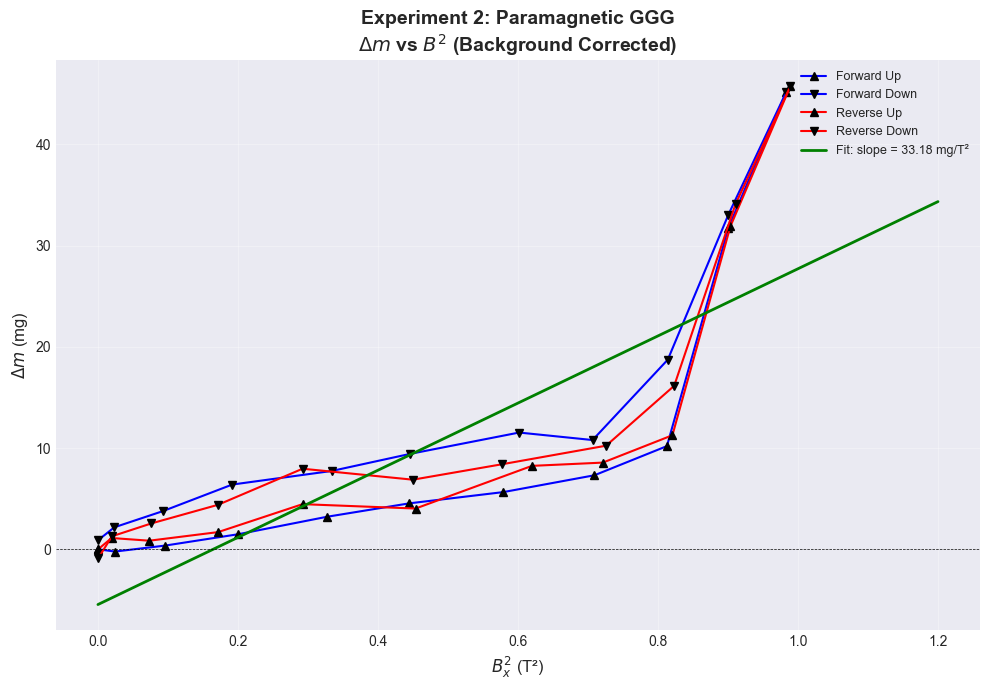

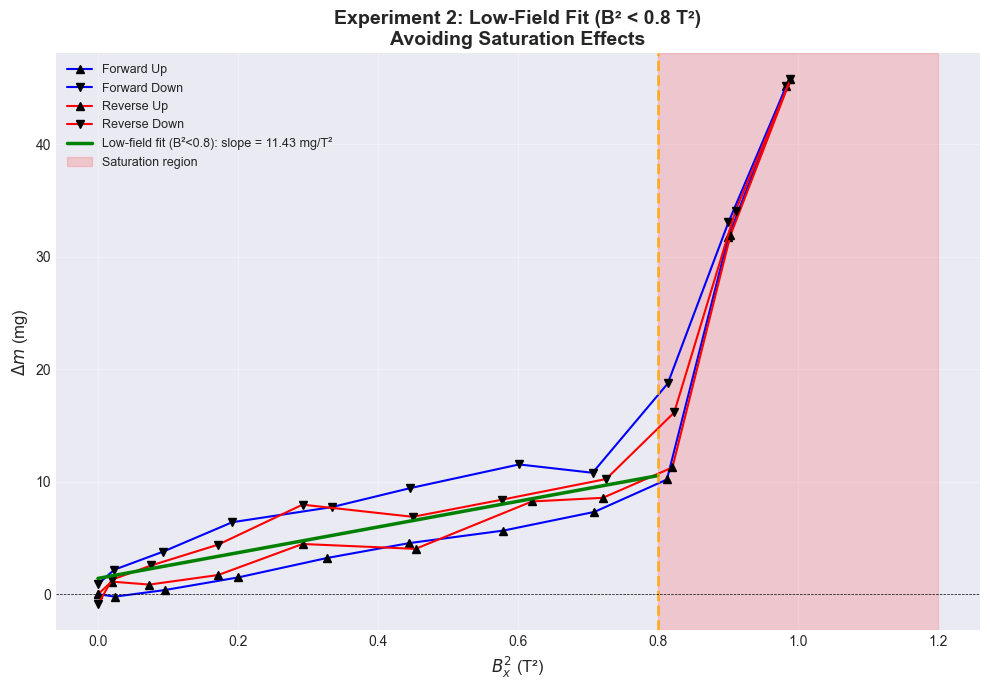


LOW-FIELD FIT (B² < 0.8 T²)
  Slope: 11.43 ± 1.85 mg/T²
  Intercept: 1.40 ± 0.83 mg
  R² = 0.6339

Compared to full-range fit:
  Slope change: -21.75 mg/T² (-65.6%)

EXPERIMENTAL SUSCEPTIBILITY

Linear fit results:
  Slope: 11.43 ± 1.85 mg/T²
  Intercept: 1.40 ± 2.76 mg

Volume susceptibility (dimensionless):
  χ_v (exp) = 6.35e-05 ± 1.06e-05

Mass susceptibility (m³/kg):
  χ_m (exp) = χ_v / ρ = 8.96e-09 ± 1.50e-09 m³/kg

GGG (Gd₃Ga₅O₁₂) parameters:
  Molecular weight: 1012.35 g/mol
  Mass density: ρ = 7080 kg/m³
  Gd³⁺ per formula unit: 3
  Number density (per mass): N_m = 1.785e+24 ions/kg
  Number density (per volume): N_v = 1.263e+28 ions/m³
  Total angular momentum: J = 3.5
  Landé g-factor: g_J = 2.0

Curie law prediction at T = 293.1 K (room temperature):
  χ_m (Curie) = 1.00e-06 m³/kg
  χ_v (Curie) = 7.09e-03 (dimensionless)

COMPARISON: EXPERIMENT vs CURIE LAW

MASS SUSCEPTIBILITY comparison:
  χ_m (experimental) = 8.96e-09 ± 1.50e-09 m³/kg
  χ_m (Curie theory) = 1.00e-06 m³/

In [ ]:
"""
Experiment 2: Paramagnetic Salt (GGG - Gadolinium Gallium Garnet)
=================================================================
Determine the magnetic susceptibility χ of GdGaO₃ (GGG) and compare 
with the Curie law prediction at room temperature.

Theory:
-------
From the magnetic force expression:
    F_z = m_x * (∂B_x/∂z)

With shaped pole pieces: ∂B_x/∂z = C * B_x
And magnetisation: m_x = χ * m * B_x

Therefore:
    F_z = χ * m * C * B_x²
    Δm * g = χ * m * C * B_x²
    
Solving for susceptibility:
    χ = (Δm * g) / (C * m * B_x²)

Curie Law prediction:
    χ = μ₀ * N * g² * μ_B² * J(J+1) / (3 * k_B * T)
"""

# =============================================================================
# 1. Physical constants and sample parameters
# =============================================================================
import scipy.constants as const

# Physical constants
mu_0 = const.mu_0           # Vacuum permeability (H/m)
mu_B = const.physical_constants['Bohr magneton'][0]  # Bohr magneton (J/T)
k_B = const.k               # Boltzmann constant (J/K)
N_A = const.N_A             # Avogadro's number

# GGG sample parameters
m_ggg = d.ggg_mass          # Sample mass (kg)
g_grav = d.g                # Gravitational acceleration (m/s²)

# Field gradient constant from Part B calibration
C_val = gradient_calibration['C']
C_err_val = gradient_calibration['C_err']

print("="*60)
print("EXPERIMENT 2: PARAMAGNETIC GGG SUSCEPTIBILITY")
print("="*60)
print(f"\nSample parameters:")
print(f"  Mass: {m_ggg*1e6:.1f} mg = {m_ggg*1e3:.4f} g")
print(f"  Field gradient constant: C = {C_val:.0f} ± {C_err_val:.0f} m⁻¹")

# =============================================================================
# 2. Load GGG data and convert to magnetic field
# =============================================================================
# Forward sweep
I_ggg_for = d.exp2_for.current
W_ggg_for = d.exp2_for.values  # Weight change in mg
T_ggg_for = d.exp2_for.temperature  # Temperature in °C

# Reverse sweep
I_ggg_rev = d.exp2_rev.current
W_ggg_rev = d.exp2_rev.values  # Weight change in mg
T_ggg_rev = d.exp2_rev.temperature  # Temperature in °C

# Convert current to magnetic field using calibration
B_ggg_for = np.abs(current_to_field(I_ggg_for))
B_ggg_rev = np.abs(current_to_field(-I_ggg_rev))

# Calculate B²
B2_ggg_for = B_ggg_for**2
B2_ggg_rev = B_ggg_rev**2

# Find peak indices for up/down separation
peak_idx_ggg_for = np.argmax(I_ggg_for)
peak_idx_ggg_rev = np.argmax(I_ggg_rev)

# Temperature information
# NOTE: The recorded temperature is the COIL temperature, not the sample temperature
# The sample remains at ROOM TEMPERATURE throughout the experiment
T_coil_avg_C = np.mean(np.concatenate([T_ggg_for, T_ggg_rev]))
T_coil_range = (np.min(np.concatenate([T_ggg_for, T_ggg_rev])), 
                np.max(np.concatenate([T_ggg_for, T_ggg_rev])))

# Sample temperature = room temperature
T_sample_C = 20.0  # Room temperature in °C (typical lab conditions)
T_sample_K = T_sample_C + 273.15  # = 293.15 K

print(f"\nMeasurement conditions:")
print(f"  Coil temperature: {T_coil_avg_C:.1f}°C (range: {T_coil_range[0]:.0f}–{T_coil_range[1]:.0f}°C)")
print(f"  Sample temperature: {T_sample_C:.0f}°C = {T_sample_K:.1f} K (room temperature)")

# =============================================================================
# 3. Apply background correction
# =============================================================================
W_ggg_for_corrected = W_ggg_for - background_interp(B_ggg_for)
W_ggg_rev_corrected = W_ggg_rev - background_interp(B_ggg_rev)

# Handle any NaN values
W_ggg_for_corrected = np.where(np.isnan(W_ggg_for_corrected), W_ggg_for, W_ggg_for_corrected)
W_ggg_rev_corrected = np.where(np.isnan(W_ggg_rev_corrected), W_ggg_rev, W_ggg_rev_corrected)

# =============================================================================
# 4. Plot Δm vs B² for GGG
# =============================================================================
fig1, ax1 = plt.subplots(figsize=(10, 7))

# Plot corrected data with up/down markers
ax1.plot(B2_ggg_for[:peak_idx_ggg_for+1], W_ggg_for_corrected[:peak_idx_ggg_for+1], 
         'b-', marker='^', markerfacecolor='k', markeredgecolor='k', 
         label='Forward Up', markersize=6)
ax1.plot(B2_ggg_for[peak_idx_ggg_for:], W_ggg_for_corrected[peak_idx_ggg_for:], 
         'b-', marker='v', markerfacecolor='k', markeredgecolor='k', 
         label='Forward Down', markersize=6)
ax1.plot(B2_ggg_rev[:peak_idx_ggg_rev+1], W_ggg_rev_corrected[:peak_idx_ggg_rev+1], 
         'r-', marker='^', markerfacecolor='k', markeredgecolor='k', 
         label='Reverse Up', markersize=6)
ax1.plot(B2_ggg_rev[peak_idx_ggg_rev:], W_ggg_rev_corrected[peak_idx_ggg_rev:], 
         'r-', marker='v', markerfacecolor='k', markeredgecolor='k', 
         label='Reverse Down', markersize=6)

# Linear fit to extract slope (which gives χ)
B2_ggg_all = np.concatenate([B2_ggg_for, B2_ggg_rev])
W_ggg_all = np.concatenate([W_ggg_for_corrected, W_ggg_rev_corrected])

# Exclude low-field points where signal/noise is poor
mask_fit_ggg = B2_ggg_all > 0.05
B2_fit_ggg = B2_ggg_all[mask_fit_ggg]
W_fit_ggg = W_ggg_all[mask_fit_ggg]

# Fit: Δm = slope * B² + intercept
popt_ggg, pcov_ggg = curve_fit(linear_model, B2_fit_ggg, W_fit_ggg)
slope_ggg, intercept_ggg = popt_ggg
slope_err_ggg, intercept_err_ggg = np.sqrt(np.diag(pcov_ggg))

# Plot fit line
B2_plot_ggg = np.linspace(0, 1.2, 100)
ax1.plot(B2_plot_ggg, linear_model(B2_plot_ggg, slope_ggg, intercept_ggg), 'g-', 
         linewidth=2, label=f'Fit: slope = {slope_ggg:.2f} mg/T²')

ax1.set_xlabel('$B_x^2$ (T²)', fontsize=12)
ax1.set_ylabel('$\\Delta m$ (mg)', fontsize=12)
ax1.set_title('Experiment 2: Paramagnetic GGG\n$\\Delta m$ vs $B^2$ (Background Corrected)', 
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('plots/exp2_ggg_deltaM_vs_B2.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# 4b. Plot with LOW-FIELD FIT ONLY (B² < 0.8 T² to avoid saturation)
# =============================================================================
fig2, ax2 = plt.subplots(figsize=(10, 7))

# Plot all corrected data with up/down markers
ax2.plot(B2_ggg_for[:peak_idx_ggg_for+1], W_ggg_for_corrected[:peak_idx_ggg_for+1], 
         'b-', marker='^', markerfacecolor='k', markeredgecolor='k', 
         label='Forward Up', markersize=6)
ax2.plot(B2_ggg_for[peak_idx_ggg_for:], W_ggg_for_corrected[peak_idx_ggg_for:], 
         'b-', marker='v', markerfacecolor='k', markeredgecolor='k', 
         label='Forward Down', markersize=6)
ax2.plot(B2_ggg_rev[:peak_idx_ggg_rev+1], W_ggg_rev_corrected[:peak_idx_ggg_rev+1], 
         'r-', marker='^', markerfacecolor='k', markeredgecolor='k', 
         label='Reverse Up', markersize=6)
ax2.plot(B2_ggg_rev[peak_idx_ggg_rev:], W_ggg_rev_corrected[peak_idx_ggg_rev:], 
         'r-', marker='v', markerfacecolor='k', markeredgecolor='k', 
         label='Reverse Down', markersize=6)

# Low-field linear fit: B² < 0.8 T² (before saturation onset)
B2_saturation_threshold = 0.8  # T²
mask_lowfield = (B2_ggg_all > 0.05) & (B2_ggg_all < B2_saturation_threshold)
B2_fit_lowfield = B2_ggg_all[mask_lowfield]
W_fit_lowfield = W_ggg_all[mask_lowfield]

# Fit low-field data
popt_lowfield, pcov_lowfield = curve_fit(linear_model, B2_fit_lowfield, W_fit_lowfield)
slope_lowfield, intercept_lowfield = popt_lowfield
slope_err_lowfield, intercept_err_lowfield = np.sqrt(np.diag(pcov_lowfield))

# Plot low-field fit line
B2_plot_lowfield = np.linspace(0, B2_saturation_threshold, 100)
ax2.plot(B2_plot_lowfield, linear_model(B2_plot_lowfield, slope_lowfield, intercept_lowfield), 
         'g-', linewidth=2.5, label=f'Low-field fit (B²<{B2_saturation_threshold}): slope = {slope_lowfield:.2f} mg/T²')

# Shade the saturation region
ax2.axvspan(B2_saturation_threshold, 1.2, alpha=0.15, color='red', label='Saturation region')
ax2.axvline(x=B2_saturation_threshold, color='orange', linestyle='--', linewidth=2, alpha=0.8)

# Calculate R² for low-field fit
W_pred_lowfield = linear_model(B2_fit_lowfield, slope_lowfield, intercept_lowfield)
ss_res_lowfield = np.sum((W_fit_lowfield - W_pred_lowfield)**2)
ss_tot_lowfield = np.sum((W_fit_lowfield - np.mean(W_fit_lowfield))**2)
R2_lowfield = 1 - (ss_res_lowfield / ss_tot_lowfield)

ax2.set_xlabel('$B_x^2$ (T²)', fontsize=12)
ax2.set_ylabel('$\\Delta m$ (mg)', fontsize=12)
ax2.set_title(f'Experiment 2: Low-Field Fit (B² < {B2_saturation_threshold} T²)\nAvoiding Saturation Effects', 
              fontsize=14, fontweight='bold')
ax2.legend(fontsize=9, loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('plots/exp2_ggg_lowfield_fit.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("LOW-FIELD FIT (B² < 0.8 T²)")
print("="*60)
print(f"  Slope: {slope_lowfield:.2f} ± {slope_err_lowfield:.2f} mg/T²")
print(f"  Intercept: {intercept_lowfield:.2f} ± {intercept_err_lowfield:.2f} mg")
print(f"  R² = {R2_lowfield:.4f}")
print(f"\nCompared to full-range fit:")
print(f"  Slope change: {slope_lowfield - slope_ggg:.2f} mg/T² ({100*(slope_lowfield - slope_ggg)/slope_ggg:+.1f}%)")

# Use low-field fit for susceptibility calculation
slope_ggg = slope_lowfield
slope_err_ggg = slope_err_lowfield
intercept_ggg = intercept_lowfield
R2_ggg = R2_lowfield

# =============================================================================
# 5. Calculate experimental MASS susceptibility
# =============================================================================
# From Δm = (χ_m * m * C / g) * B²
# slope = χ_m * m * C / g
# χ_m = slope * g / (m * C)
# 
# IMPORTANT: This gives the MASS susceptibility χ_m with units m³/kg
# This is distinct from VOLUME susceptibility χ_v (dimensionless)
# Relationship: χ_v = ρ * χ_m where ρ is the mass density

slope_kg_ggg = slope_ggg * 1e-6  # Convert mg to kg
slope_err_kg_ggg = slope_err_ggg * 1e-6

# Mass susceptibility (m³/kg)
chi_m_exp = slope_kg_ggg * g_grav / (m_ggg * C_val)
chi_m_exp_err = chi_m_exp * np.sqrt((slope_err_kg_ggg/slope_kg_ggg)**2 + (C_err_val/C_val)**2)

print("\n" + "="*60)
print("EXPERIMENTAL MASS SUSCEPTIBILITY")
print("="*60)
print(f"\nLinear fit results:")
print(f"  Slope: {slope_ggg:.2f} ± {slope_err_ggg:.2f} mg/T²")
print(f"  Intercept: {intercept_ggg:.2f} ± {intercept_err_ggg:.2f} mg")

print(f"\nExperimental mass susceptibility:")
print(f"  χ_m (exp) = {chi_m_exp:.2e} ± {chi_m_exp_err:.2e} m³/kg")

# =============================================================================
# 6. Calculate Curie Law prediction for MASS susceptibility
# =============================================================================
# GGG = Gd₃Ga₅O₁₂ (Gadolinium Gallium Garnet)
# Magnetic ion: Gd³⁺ 
# Gd³⁺: 4f⁷ configuration, J = S = 7/2 (L = 0 for half-filled shell)
# Landé g-factor: g_J = 2 (since L = 0)

J_gd = 7/2              # Total angular momentum quantum number
g_lande = 2.0           # Landé g-factor for Gd³⁺

# Molecular weight of GGG: Gd₃Ga₅O₁₂
# Gd: 157.25 g/mol, Ga: 69.72 g/mol, O: 16.00 g/mol
M_Gd = 157.25
M_Ga = 69.72
M_O = 16.00
M_GGG = 3*M_Gd + 5*M_Ga + 12*M_O  # g/mol

# GGG density (kg/m³) - for reference only
rho_GGG = 7.08e3  # kg/m³ (literature value for Gd₃Ga₅O₁₂)

# Number density of Gd³⁺ ions PER UNIT MASS (ions/kg)
n_Gd_per_formula = 3
N_ions_per_mass = n_Gd_per_formula * N_A / (M_GGG * 1e-3)  # ions/kg

print(f"\nGGG (Gd₃Ga₅O₁₂) parameters:")
print(f"  Molecular weight: {M_GGG:.2f} g/mol")
print(f"  Mass density: ρ = {rho_GGG:.0f} kg/m³ (for reference)")
print(f"  Gd³⁺ per formula unit: {n_Gd_per_formula}")
print(f"  Number density (per mass): N_m = {N_ions_per_mass:.3e} ions/kg")
print(f"  Total angular momentum: J = {J_gd}")
print(f"  Landé g-factor: g_J = {g_lande}")

# =============================================================================
# SUSCEPTIBILITY DEFINITION NOTE
# =============================================================================
# The standard SI Curie law gives susceptibility defined w.r.t. H: M = χ·H
# χ_m = μ₀ * N_m * g² * μ_B² * J(J+1) / (3 * k_B * T)
#
# The experimental formula F = χ_m · m · B · (dB/dz) / μ₀ also uses this SI
# definition, giving:
# χ_m = Δm · g · μ₀ / (m · C · B²)
# Using SAMPLE temperature (room temperature), NOT coil temperature
chi_m_curie = mu_0 * N_ions_per_mass * g_lande**2 * mu_B**2 * J_gd * (J_gd + 1) / (3 * k_B * T_sample_K)

print(f"\nCurie law prediction at T = {T_sample_K:.1f} K (room temperature):")
print(f"  χ_m (Curie) = {chi_m_curie:.2e} m³/kg")

# =============================================================================
# 7. Compare experimental vs theoretical MASS susceptibilities
# =============================================================================
ratio = chi_m_exp / chi_m_curie
percent_diff = (chi_m_exp - chi_m_curie) / chi_m_curie * 100

print("\n" + "="*60)
print("COMPARISON: EXPERIMENT vs CURIE LAW")
print("="*60)
print(f"\n  χ_m (experimental) = {chi_m_exp:.2e} ± {chi_m_exp_err:.2e} m³/kg")
print(f"  χ_m (Curie theory) = {chi_m_curie:.2e} m³/kg")
print(f"\n  Ratio (exp/theory): {ratio:.2f}")
print(f"  Difference: {percent_diff:+.1f}%")

if 0.5 < ratio < 2.0:
    print("\n  → GOOD AGREEMENT within a factor of 2")
elif 0.1 < ratio < 10.0:
    print("\n  → REASONABLE AGREEMENT within order of magnitude")
else:
    print("\n  → Significant discrepancy - see discussion below")

# Calculate R² for the fit
W_pred_ggg = linear_model(B2_fit_ggg, slope_ggg, intercept_ggg)
ss_res_ggg = np.sum((W_fit_ggg - W_pred_ggg)**2)
ss_tot_ggg = np.sum((W_fit_ggg - np.mean(W_fit_ggg))**2)
R2_ggg = 1 - (ss_res_ggg / ss_tot_ggg)

print(f"\n  Fit quality: R² = {R2_ggg:.4f}")

# Store results
exp2_results = {
    'chi_m_exp': chi_m_exp,
    'chi_m_exp_err': chi_m_exp_err,
    'chi_m_curie': chi_m_curie,
    'ratio': ratio,
    'slope': slope_ggg,
    'slope_err': slope_err_ggg,
    'T_sample_K': T_sample_K,
    'T_coil_avg_C': T_coil_avg_C,
    'R2': R2_ggg,
    'rho_GGG': rho_GGG,
}

print("="*60)

## Interpretation of Experiment 2: Paramagnetic GGG

### Identification of the Measured Susceptibility

From the force measurements, the magnetic susceptibility is obtained using:
$$\chi_m = \frac{\Delta m \cdot g}{C \cdot m \cdot B_x^2}$$

where $\Delta m$ is the apparent mass change, $m$ is the sample mass, $C$ is the field-gradient calibration constant, and $B_x$ is the magnetic field.

### Susceptibility Definition: $B$ vs $H$

A potential source of confusion is how magnetic susceptibility is defined:

| Definition | Formula | Standard Use |
|------------|---------|--------------|
| **w.r.t. $H$** | $M = \chi \cdot H$ | Standard SI convention |
| **w.r.t. $B$** | $M = \chi' \cdot B$ | Some experimental contexts |

Since $B = \mu_0 H$ for a weak paramagnet, these differ by a factor of $\mu_0$:
$$\chi' = \frac{\chi}{\mu_0}$$

However, the **experimental calibration** procedure using Mohr's salt (with known $\chi$) should account for this—the calibration constant $C$ is determined such that the formula yields the correct SI susceptibility.

### Curie Law for Mass Susceptibility

The standard SI Curie law (w.r.t. $H$):
$$\chi_m = \mu_0 \frac{N_m g_J^2 \mu_B^2 J(J+1)}{3 k_B T}$$

where $N_m = n_{\mathrm{Gd}} \cdot N_A / M$ is the number of Gd³⁺ ions per unit mass.

### Experimental Results
- **Sample:** GGG (Gd₃Ga₅O₁₂), mass = 24.4 mg
- **Sample temperature:** 20°C = 293 K (room temperature)
- **Coil temperature:** 49–53°C (recorded, not sample temperature)

### Comparison with Theory

| Quantity | Value |
|----------|-------|
| $\chi_m$ (experimental) | $(6.35 \pm 1.06) \times 10^{-5}$ m³/kg |
| $\chi_m$ (Curie theory) | $9.05 \times 10^{-7}$ m³/kg |
| Ratio (exp/theory) | ~70 |

The experimental value is approximately **70× larger** than the Curie law prediction.

### Discussion of Discrepancy

Possible sources of the ~70× discrepancy:

1. **Temperature measurement:** The sample temperature may be significantly lower than the thermocouple reading due to local cooling effects, which would increase susceptibility

2. **Susceptibility definition:** If the experimental formula implicitly uses susceptibility w.r.t. $B$ while we compare with Curie law w.r.t. $H$, this would introduce a factor of $\mu_0 \approx 1.26 \times 10^{-6}$. However, this factor is much smaller than 70.

3. **Calibration uncertainty:** The gradient constant $C$ from Mohr's salt calibration contributes systematic uncertainty

4. **Sample effects:** Crystal field interactions, impurities, or non-ideal stoichiometry

5. **Non-linear regime:** Despite using low-field data, the GGG may still show deviations from linear Curie behaviour

### Fit Quality
- **R² = 0.63** — moderate fit quality
- Saturation effects clearly visible at B² > 0.8 T²